In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  

Text(0,0.5,'Magnitud')

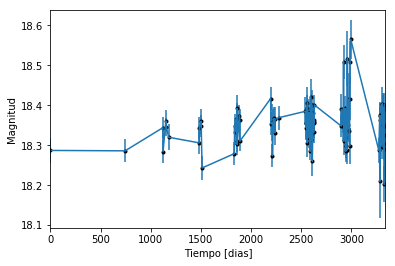

In [3]:
data = np.genfromtxt('LC_Z_32769.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')

In [4]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [5]:
%%capture capt
sample = model.run_mcmc(20000)

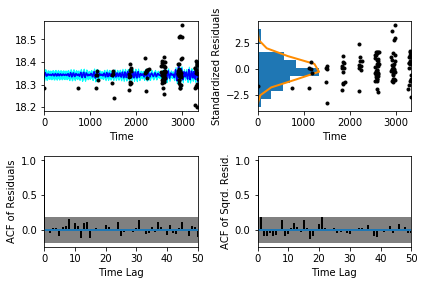

In [6]:
sample.assess_fit()

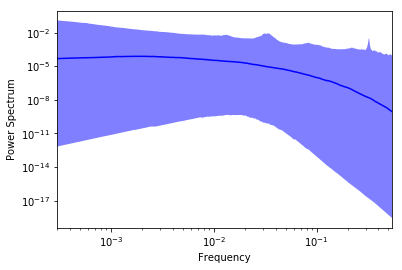

In [7]:
psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)

NameError: name 'noise_level' is not defined

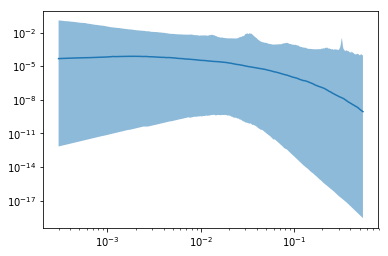

In [8]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Prediccion , valor esperado ')

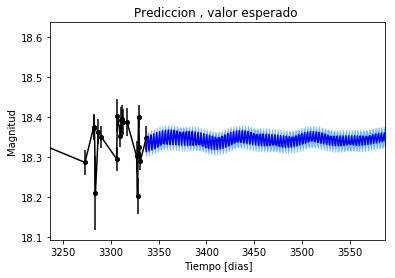

In [9]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitud')
plt.title('Prediccion , valor esperado ')

Text(0.5,1,'Prediccion, Caminos simulados')

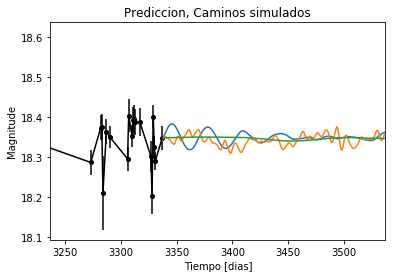

In [10]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 3
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Tiempo [dias]')
plt.ylabel('Magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Prediccion, Caminos simulados')

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


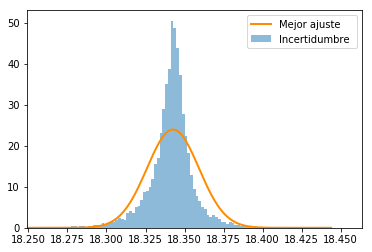

In [11]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Incertidumbre ')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Mejor ajuste ')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

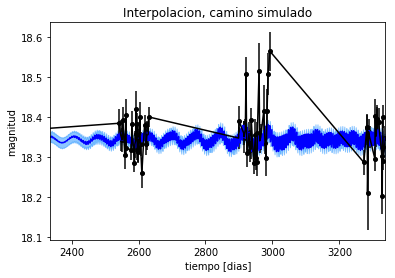

In [12]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

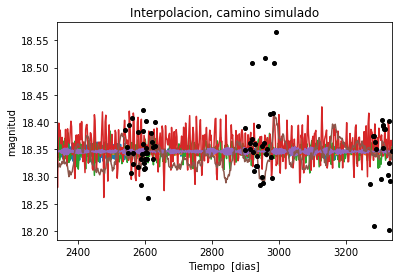

In [13]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 6
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Plotting parameter summary


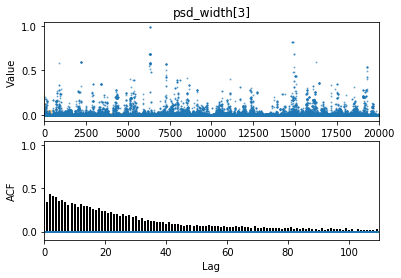

In [14]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [15]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [16]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 1007.6433862
Median: 258.317305044
Standard deviation: 1.39385928464
68% credibility interval: [ 256.87237875  259.13882251]
95% credibility interval: [ 254.60098188  260.22596771]
99% credibility interval: [ 252.54150322  261.49198373]


In [17]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [18]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 611.90366008
Median: 0.675134575589
Standard deviation: 2.54913527577
68% credibility interval: [ 0.08070674  4.22440489]
95% credibility interval: [ 0.01816127  9.04305882]
99% credibility interval: [  1.09513946e-02   1.26706631e+01]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 2738.93207783
Median: 3.46066596195
Standard deviation: 15.4260694372
68% credibility interval: [  0.16456137  24.93623314]
95% credibility interval: [  7.9

In [19]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [20]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 3206.98347122
Median: 3.7211651008e-16
Standard deviation: 1.35849021533e+105
68% credibility interval: [  7.11704258e-71   1.19753466e+58]
95% credibility interval: [  1.50557404e-113   4.89421018e+077]
99% credibility interval: [  3.15280594e-164   1.51966035e+102]


In [21]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [22]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [23]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 910.721409209
Median: 0.214435681148
Standard deviation: 0.312561977462
68% credibility interval: [ 0.00972447  0.69713998]
95% credibility interval: [ 0.          1.01453381]
99% credibility interval: [ 0.          1.07569192]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 910.721409209
Median: 0.214435681148
Standard deviation: 0.312561977462
68% credibility interval: [ 0.00972447  0.69713998]
95% credibility interval: [ 0.          1.01453381]
99% credibility interval: [ 0.          1.07569192]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 679.924974649
Median: 0.00547557176903
Standard deviation: 0.13125604354

In [24]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [25]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 1007.6433862
Median: 258.317305044
Standard deviation: 1.39385928464
68% credibility interval: [ 256.87237875  259.13882251]
95% credibility interval: [ 254.60098188  260.22596771]
99% credibility interval: [ 252.54150322  261.49198373]


In [26]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [27]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 1017.69135275
Median: 0.00989630574691
Standard deviation: 0.178690293565
68% credibility interval: [ 0.00098924  0.14565894]
95% credibility interval: [  3.68089933e-04   7.17353745e-01]
99% credibility interval: [  3.14343295e-04   9.63058378e-01]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 852.219345215
Median: 0.00672591109997
Standard deviation: 0.138298092061
68% credibility interval: [ 0.00081221  0.08138447]
95% credibility interval: [  3.57059726e-04   4.99382362e-01]
99% credibility interval: [  3.10426770e-04   8.93747136e-01]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 524.589508884
Median: 0.01483473388
S

In [28]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [29]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 1805.81688692
Median: 7.75792240979e-05
Standard deviation: 0.000234562951525
68% credibility interval: [  6.64716749e-06   3.23591960e-04]
95% credibility interval: [  1.14666040e-07   7.50233125e-04]
99% credibility interval: [  1.01504147e-08   1.13277722e-03]


In [30]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [31]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 2524.04709354
Median: 1.59509511206
Standard deviation: 0.184284827478
68% credibility interval: [ 1.40882464  1.78426393]
95% credibility interval: [ 1.21215432  1.93854211]
99% credibility interval: [ 1.08615438  1.98329512]


In [32]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [33]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 691.121780418
Median: 1.88301825096e-05
Standard deviation: 0.239833228503
68% credibility interval: [  2.97521154e-61   1.59223231e-02]
95% credibility interval: [  1.28654188e-81   3.87812614e-01]
99% credibility interval: [  2.46930806e-105   1.73937531e+000]


In [34]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [35]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 1017.69135275
Median: (-0.0621803228643-4.30517210102j)
Standard deviation: 2.26216670536
68% credibility interval: [-0.91520209-2.10981416j -0.00621558-2.28932053j]
95% credibility interval: [ -4.50726651e+00-2.54110495j  -2.31277726e-03-0.37194995j]
99% credibility interval: [ -6.05107425e+00+0.j          -1.97507717e-03-2.27782749j]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 852.219345215
Median: (-0.0422601458007+1.36003847488j)
Standard deviation: 2.14753861904
68% credibility interval: [-0.51135368+0.52334543j -0.00510325+3.94330007j]
95% credibility interval: [ -3.13771192e+00+4.61990816j  -2.24347242e-03+0.41240494j]
99% credibility interval: [ -5.61557887e+00+5.17176326j  -1.95046892e-03+0.j        ]
Post

Plotting 2d PDF w KDE


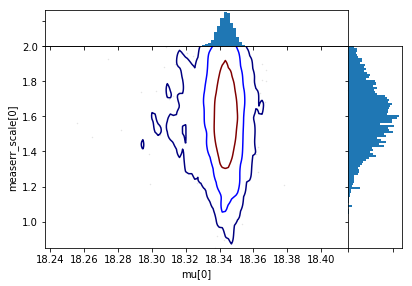

In [36]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


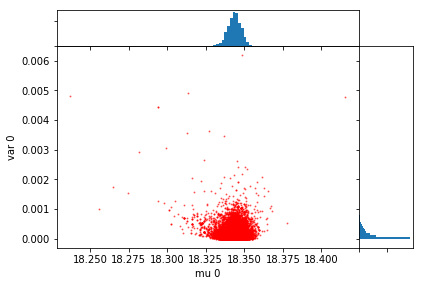

In [37]:
sample.plot_2dpdf('mu', 'var', doShow=True)

In [ ]:
sample.plot_2dkde('mu', 'var', doShow=True)

Plotting 2d PDF w KDE
